In [3]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Initialize Random Seed

In [4]:
import random
random.seed(42)

# Import Training and Validation Sets

In [5]:
df = pd.read_csv('../data/sarcasm/train.csv')
val_hate = pd.read_csv('../data/sarcasm/val.csv')

# Preprocessing of text 

In [6]:


def clean_text(x):
    x = re.sub(r'http\S+|www\S+|https\S+', '', str(x))
    x = re.sub(r'\s+', ' ', x)
    x = re.sub(r'[^a-zA-Z0-9\s]', '', x)
    x = re.sub(r'\d+', '', x)
    x = re.sub(r'[^\w\s]', '', x)
    x = re.sub(r'#', '', x)
    x = re.sub(r'\s+', ' ', x)
    x = x.strip()
    x = x.lower()
    return x

df['Sentence'] = df['Sentence'].apply(clean_text)

# Create Vocabulary

In [7]:

# Create Vocabulary
vocab = Counter(word for sentence in df['Sentence'] for word in sentence.split())
word2idx = {word: i for i, (word, _) in enumerate(vocab.items())}
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(word2idx)
print("Vocabulary size:", vocab_size)

Vocabulary size: 14558


# Word2Vec Model

In [8]:


class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, target, context):
        target_emb = self.embeddings(target)  # (batch_size, embed_dim)
        context_emb = self.output_embeddings(context)  # (batch_size, embed_dim)
        scores = torch.sum(target_emb * context_emb, dim=1)  # Dot product similarity
        return scores

# Using Cuda to run the code on GPU

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
model = Word2Vec(vocab_size, 100).to(device)

# t-SNE Visualization of word Embeddings 

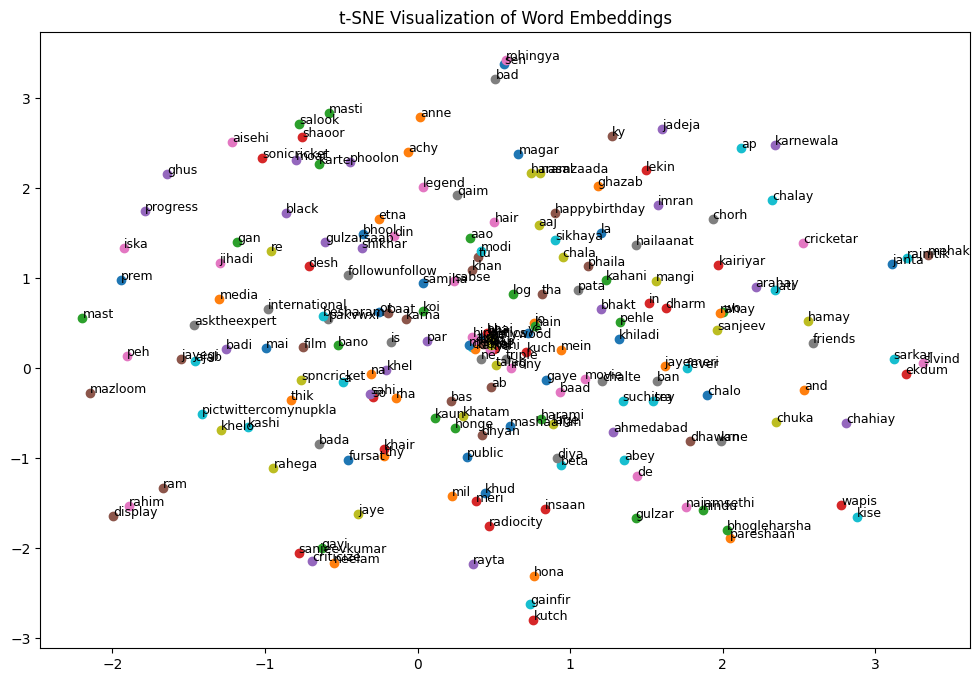

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load saved embeddings
embedding_dict = np.load("./embeddings/word_embeddings_100epochs_cleantext.npy", allow_pickle=True).item()





# Convert to tensor
vocab_size = len(embedding_dict)
embedding_dim = len(next(iter(embedding_dict.values())))  # Get embedding size

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word2idx = {word: idx for idx, word in enumerate(embedding_dict.keys())}

for word, idx in word2idx.items():
    embedding_matrix[idx] = embedding_dict[word]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)




# Select 200 most frequent words for visualization
top_words = list(embedding_dict.keys())[:200]
top_embeddings = np.array([embedding_dict[word] for word in top_words])


# Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(top_embeddings)

# Plot embeddings
plt.figure(figsize=(12, 8))
for i, word in enumerate(top_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


# Cosine Similarity

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_words(target_word, top_n=5):
    if target_word not in embedding_dict:
        print("Word not in vocabulary!")
        return

    target_embedding = embedding_dict[target_word].reshape(1, -1)
    all_words = list(embedding_dict.keys())
    all_embeddings = np.array([embedding_dict[word] for word in all_words])

    # Compute cosine similarity
    similarities = cosine_similarity(target_embedding, all_embeddings)[0]
    top_indices = similarities.argsort()[-top_n-1:-1][::-1]

    # Display similar words
    print(f"Words similar to '{target_word}':")
    for idx in top_indices:
        print(f"{all_words[idx]} (Similarity: {similarities[idx]:.4f})")

# Example usage
find_similar_words("maa")


Words similar to 'maa':
chahiyenoonekilledjessica (Similarity: 0.3899)
aisa (Similarity: 0.3835)
ramrahim (Similarity: 0.3669)
wala (Similarity: 0.3658)
mohammadkaif (Similarity: 0.3616)


In [13]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = pd.read_csv("../data/sarcasm/train.csv")
df['Sentence'] = df['Sentence'].apply(clean_text)

# Convert text to sequences of word indices
def text_to_sequence(text):
    return [word2idx[word] for word in text.split() if word in word2idx]

df["sequence"] = df["Sentence"].apply(text_to_sequence)

# Padding sequences to the same length
MAX_LEN = 100  # Choose max sentence length
def pad_sequence(seq, max_len=MAX_LEN):
    return seq[:max_len] + [0] * (max_len - len(seq))  # Pad with zeros if shorter

df["padded_seq"] = df["sequence"].apply(lambda x: pad_sequence(x))

# Convert labels to numerical valuesZ
label_mapping = {"sarcasm": 0, "non-sarcasm": 1,}  # Adjust if needed
df["label"] = df["Tag"].astype(int)

# Making dataloaders for training

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create dataset
dataset = HateSpeechDataset(df["padded_seq"].tolist(), df["label"].tolist())

# DataLoader
BATCH_SIZE = 64
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
# BASE MODEL 


# class FFNNClassifier(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
#         super(FFNNClassifier, self).__init__()
#         self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
#         self.fc1 = nn.Linear(embedding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, num_classes)

#     def forward(self, x):
#         x = self.embedding(x)  # (batch_size, max_len, embed_dim)
#         x = torch.mean(x, dim=1)  # Average word embeddings (batch_size, embed_dim)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x  # No softmax, as we'll use CrossEntropyLoss


# REFINED MODEL WITH DROPOUT AND LAYER NORM

class FFNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout=0.3):
        super(FFNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.norm2 = nn.LayerNorm(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)

        self.out = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, max_len, embed_dim)
        x = torch.mean(x, dim=1)  # (batch_size, embed_dim)

        x = F.relu(self.norm1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.out(x)
        return x


In [16]:

# import torch.optim as optim

# embedding_dim = 100  # Same as the embedding dimension used in Word2Vec
# # Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # device = torch.device("cuda:0")

# # Initialize model
# model = FFNNClassifier(vocab_size, embedding_dim, hidden_dim=64, num_classes=2).to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# from tqdm import tqdm

# EPOCHS = 100
# for epoch in range(EPOCHS):
#     total_loss = 0
#     model.train()
    
#     loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

#     for sequences, labels in loop:
#         sequences, labels = sequences.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(sequences)
#         loss = criterion(outputs, labels)
#         loss.backward()
        
#         optimizer.step()
        
#         total_loss += loss.item()
#         loop.set_postfix(loss=loss.item())  # Show loss in tqdm

#     print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {total_loss / len(dataloader):.4f}")


# Saving and Loading the model

In [17]:
# torch.save(model.state_dict(), "./model/REFINED_ffnn_classifier_97sarcasmf1_100epoch_cleantext_14kvocab.pth")

# Model Evaluation

In [18]:
#Loading the saved model
model = FFNNClassifier(vocab_size, embedding_dim, hidden_dim=64, num_classes=2).to(device)
model.load_state_dict(torch.load("./model/REFINED_ffnn_classifier_97sarcasmf1_100epoch_cleantext_14kvocab.pth"))
model.eval()


FFNNClassifier(
  (embedding): Embedding(14558, 100)
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, dataloader, device, label_names=["hate", "non-hate"]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(dataloader, desc="Evaluating"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predictions = torch.argmax(outputs, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Accuracy: {acc:.4f}")

    # Classification Report
    print("\n📄 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [20]:
# Clean the text
val_hate['Sentence'] = val_hate['Sentence'].apply(clean_text)

# Convert text to word index sequences
val_hate['sequence'] = val_hate['Sentence'].apply(text_to_sequence)
val_hate['padded_seq'] = val_hate['sequence'].apply(lambda x: pad_sequence(x))

# Convert label (assuming same label structure as train)
val_hate['label'] = val_hate['Tag'].astype(int)


In [21]:
# Create Dataset
val_dataset = HateSpeechDataset(val_hate["padded_seq"].tolist(), val_hate["label"].tolist())

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 25.25it/s]



✅ Accuracy: 0.9410

📄 Classification Report:
              precision    recall  f1-score   support

        hate       0.94      1.00      0.97       474
    non-hate       1.00      0.39      0.56        51

    accuracy                           0.94       525
   macro avg       0.97      0.70      0.77       525
weighted avg       0.94      0.94      0.93       525



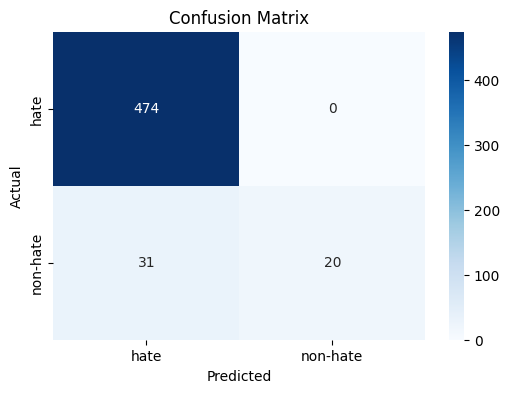

In [22]:
evaluate(model, val_loader, device)
